# Website A/B Testing - Lab

## Introduction

In this lab, you'll get another chance to practice your skills at conducting a full A/B test analysis. It will also be a chance to practice your data exploration and processing skills! The scenario you'll be investigating is data collected from the homepage of a music app page for audacity.

## Objectives

You will be able to:
* Analyze the data from a website A/B test to draw relevant conclusions
* Explore and analyze web action data

## Exploratory Analysis

Start by loading in the dataset stored in the file 'homepage_actions.csv'. Then conduct an exploratory analysis to get familiar with the data.

> Hints:
    * Start investigating the id column:
        * How many viewers also clicked?
        * Are there any anomalies with the data; did anyone click who didn't view?
        * Is there any overlap between the control and experiment groups? 
            * If so, how do you plan to account for this in your experimental design?

In [83]:
import pandas as pd
import numpy as np

from scipy import stats 
import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Your code here
df = pd.read_csv('homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8188 entries, 0 to 8187
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  8188 non-null   object
 1   id         8188 non-null   int64 
 2   group      8188 non-null   object
 3   action     8188 non-null   object
dtypes: int64(1), object(3)
memory usage: 256.0+ KB


In [7]:
df['action'].value_counts()

view     6328
click    1860
Name: action, dtype: int64

In [ ]:
df['group'].value_counts()

In [8]:
df['id'].value_counts().sort_values(ascending=False)

363314    2
348549    2
530057    2
647343    2
842634    2
         ..
391473    1
266548    1
618808    1
916304    1
343998    1
Name: id, Length: 6328, dtype: int64

In [18]:
#clicks ad views per person
#df = df.set_index('timestamp')
cv_pp = df.groupby('id')['action'].apply(lambda x: ','.join(x))
#control, expiriment, per person
ce_pp = df.groupby('id')['group'].apply(lambda x: ','.join(set(x)))
ce_pp

id
182988    experiment
182994       control
183089       control
183136    experiment
183141    experiment
             ...    
937003       control
937073       control
937108       control
937139    experiment
937217       control
Name: group, Length: 6328, dtype: object

In [19]:
ce_pp.value_counts()
# none were in both groups

control       3332
experiment    2996
Name: group, dtype: int64

In [20]:
# did anyone click without viewing
cv_pp.value_counts()
# there were no clicks without views

view          4468
view,click    1860
Name: action, dtype: int64

In [27]:
#join these into a single dataframe.
df2 = pd.merge(ce_pp, cv_pp,
               right_index = True, 
               left_index = True,
               how='outer'
)
df2.isna().sum()

group     0
action    0
dtype: int64

In [75]:
# try to create a pivot table with indicators for click and view by person.
df['count'] = 1

c1 = df[df['group'] == 'control']
e1 = df[df['group'] == 'experiment']
c1 = c1.pivot(index='id', columns ='action', values='count').fillna(0)
e1 = e1.pivot(index='id', columns ='action', values='count').fillna(0)

In [77]:
t = stats.ttest_ind(c1['click'], e1['click'], equal_var=False)
t.pvalue / 2

0.004466402814337101

## Conduct a Statistical Test

Conduct a statistical test to determine whether the experimental homepage was more effective than that of the control group.

In [66]:
#Your code here
#clickrate control
control = df2[df2['group'] == 'control']
experiment = df2[df2['group'] == 'experiment']
control_clicks = control[control['action'] == 'view,click']
experiment_clicks = experiment[experiment['action'] == 'view,click']


control_cr = len(control_clicks) / len(control)
experiment_cr = len(experiment_clicks) / len(experiment)

print(f'Control Click Rate: {control_cr}, Experiment Click Rate: {experiment_cr}')

Control Click Rate: 0.2797118847539016, Experiment Click Rate: 0.3097463284379172


In [55]:
# I have 2 means, how do I calculate p
# These are categorical so the only think I can think of is an ANOVA
df2['click'] = df2['action'].map(lambda x: 1 if x == 'view,click' else 0)
df2['group_n'] = df2['group'].map(lambda x: 1 if x == 'control' else 0)

df2

,group,action,click,group_n
id,,,,
182988,experiment,view,0,0
182994,control,"view,click",1,1
183089,control,view,0,1
183136,experiment,view,0,0
183141,experiment,"view,click",1,0
...,...,...,...,...
937003,control,view,0,1
937073,control,view,0,1
937108,control,view,0,1


In [57]:
formula = 'group_n ~ C(click)'
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

               sum_sq      df         F    PR(>F)
C(click)     1.709386     1.0  6.862145  0.008825
Residual  1575.830437  6326.0       NaN       NaN


In [68]:
0.008825/2

0.0044125

    The p value is < 0.05 so we can reject the null hypothesis.  The data suggests that the experiment group performed better.

# I don't understand how we can take a ttest on a bernoulli distribution.
I will resample to see if I get the same answer.

/srv/conda/envs/notebook/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

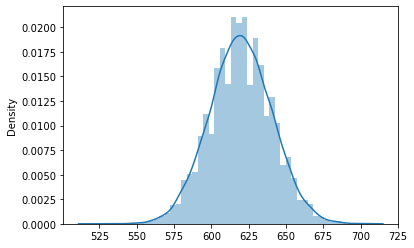

In [113]:
c_sample_means = []
e_sample_means = []

for i in range(10000):
    sample = np.random.choice(control['click'], 2000)
    c_sample_means.append(sample.sum())
    
    sample2 = np.random.choice(experiment['click'], 2000)
    e_sample_means.append(sample2.sum())
        
sns.distplot(e_sample_means)

In [112]:
print('Simulation variance:', np.var(c_sample_means))
var = 2000 * control_cr * (1-control_cr)
print('Calculated variance:', var)

print('Simulation variance:', np.var(e_sample_means))
var = 2000 * experiment_cr * (1-experiment_cr)
print('Calculated variance:', var)

Simulation variance: 420.33446399999997
Calculated variance: 402.94629256264335
Simulation variance: 420.15560000000005
Calculated variance: 427.6070809142943


In [117]:
stats.ttest_ind(c_sample_means, e_sample_means, equal_var=False)

std = click_difference / np.sqrt(var)

std_dif = click_difference / std

stats.norm.sf(std_dif, loc=0, scale=std)

1.0066873419378628e-06

## Verifying Results

One sensible formulation of the data to answer the hypothesis test above would be to create a binary variable representing each individual in the experiment and control group. This binary variable would represent whether or not that individual clicked on the homepage; 1 for they did and 0 if they did not. 

The variance for the number of successes in a sample of a binomial variable with n observations is given by:

## $n\bullet p (1-p)$

Given this, perform 3 steps to verify the results of your statistical test:
1. Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 
2. Calculate the number of standard deviations that the actual number of clicks was from this estimate. 
3. Finally, calculate a p-value using the normal distribution based on this z-score.

### Step 1:
Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 

In [35]:
#Your code here
expected_cr_experiment = len(experiment) * control_cr
expected_cr_experiment

838.0168067226891

### Step 2:
Calculate the number of standard deviations that the actual number of clicks was from this estimate.

In [109]:
#Your code here
click_difference = len(experiment_clicks) - expected_cr_experiment

control_std = np.sqrt(len(experiment) * control_cr * (1-control_cr))

experiment_std = np.sqrt(len(experiment) * experiment_cr * (1-experiment_cr))
control_std, experiment_std

(24.568547907005815, 25.30919609963171)

In [70]:
dif_in_std = click_difference / control_std
dif_in_std

3.6625360854823588

### Step 3: 
Finally, calculate a p-value using the normal distribution based on this z-score.

In [71]:
#Your code here
stats.norm.sf(dif_in_std)

0.00012486528006951198

### Analysis:

Does this result roughly match that of the previous statistical test?

> Comment: **Your analysis here**
Roughly yes, but not exactly.  Both reject the null hypothesis but by different amounts.  I think it has to do with my calculation of std.

## Summary

In this lab, you continued to get more practice designing and conducting AB tests. This required additional work preprocessing and formulating the initial problem in a suitable manner. Additionally, you also saw how to verify results, strengthening your knowledge of binomial variables, and reviewing initial statistical concepts of the central limit theorem, standard deviation, z-scores, and their accompanying p-values.